# Local Luanti Benchmark Analysis

This notebook analyzes performance metrics from Luanti server benchmarks, supporting multiple data formats:
- JSON metrics from local Telegraf monitoring
- CSV data from Yardstick DAS5 experiments  
- Server logs and custom metrics
- Bot performance data

The analysis provides insights into:
- Server CPU and memory utilization during bot load
- Network protocol performance
- Player connection patterns
- World simulation overhead

## Import Required Libraries

Import necessary libraries for data processing, visualization, and analysis.

In [1]:
import pandas as pd
import json
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from datetime import datetime, timedelta
import re
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style consistent with Yardstick examples
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

print("Libraries imported successfully!")
print(f"Analysis running on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis running on: 2025-06-12 09:16:25


## Data Source Detection and Loading

Automatically detect available Luanti benchmark data from various sources.

In [2]:
def find_luanti_data_sources():
    """Find all available Luanti benchmark data sources."""
    sources = {}
    
    # 1. Local JSON metrics (similar to Minecraft benchmark)
    json_dirs = list(Path("local_benchmark_results").glob("luanti_benchmark_*"))
    if json_dirs:
        sources['local_json'] = max(json_dirs, key=lambda x: x.name)
        
    # 2. Yardstick CSV results from DAS5
    csv_dirs = list(Path(".").glob("**/luanti_output*"))
    if csv_dirs:
        sources['yardstick_csv'] = max(csv_dirs, key=lambda x: x.name)
    
    # 3. Server logs
    log_files = list(Path("luanti_server").glob("*.txt"))
    if log_files:
        sources['server_logs'] = Path("luanti_server")
        
    # 4. Bot performance data
    bot_dirs = list(Path("bot_components").glob("**/target"))
    if bot_dirs:
        sources['bot_data'] = Path("bot_components")
        
    return sources

# Detect available data sources
data_sources = find_luanti_data_sources()
print("Available Luanti data sources:")
for source_type, path in data_sources.items():
    print(f"  {source_type}: {path}")

if not data_sources:
    print("\nNo Luanti benchmark data found!")
    print("Available options:")
    print("1. Run a local Luanti benchmark (create local_luanti_benchmark.py)")
    print("2. Copy Yardstick CSV results to this directory") 
    print("3. Check luanti_server/ for log files")

Available Luanti data sources:
  local_json: local_benchmark_results/luanti_benchmark_20250612_091500
  server_logs: luanti_server
  bot_data: bot_components


In [3]:
def load_json_metrics(metrics_file):
    """Load JSON metrics from Telegraf-style output."""
    metrics = []
    
    try:
        with open(metrics_file, 'r') as f:
            for line in f:
                try:
                    metric = json.loads(line.strip())
                    metrics.append(metric)
                except json.JSONDecodeError:
                    continue
    except FileNotFoundError:
        print(f"Metrics file not found: {metrics_file}")
        return []
    
    return metrics

def load_csv_metrics(csv_dir):
    """Load CSV metrics from Yardstick-style output."""
    metrics = {}
    
    csv_files = list(csv_dir.rglob("*.csv"))
    for csv_file in csv_files:
        metric_name = csv_file.stem
        try:
            df = pd.read_csv(csv_file)
            if not df.empty:
                metrics[metric_name] = df
        except Exception as e:
            print(f"Error loading {csv_file}: {e}")
    
    return metrics

def parse_luanti_logs(log_dir):
    """Parse Luanti server logs for performance insights."""
    log_data = []
    
    log_files = list(log_dir.glob("*.txt"))
    for log_file in log_files:
        try:
            with open(log_file, 'r') as f:
                lines = f.readlines()
                
                for i, line in enumerate(lines):
                    # Parse timestamp if available
                    timestamp_match = re.search(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line)
                    
                    # Look for player connections/disconnections
                    if 'joins game' in line or 'leaves game' in line:
                        log_data.append({
                            'timestamp': timestamp_match.group(1) if timestamp_match else None,
                            'type': 'player_connection',
                            'event': 'join' if 'joins' in line else 'leave',
                            'line': line.strip()
                        })
                    
                    # Look for performance warnings
                    elif 'lag' in line.lower() or 'slow' in line.lower():
                        log_data.append({
                            'timestamp': timestamp_match.group(1) if timestamp_match else None,
                            'type': 'performance_warning',
                            'line': line.strip()
                        })
                        
        except Exception as e:
            print(f"Error parsing {log_file}: {e}")
    
    return pd.DataFrame(log_data) if log_data else pd.DataFrame()

# Load data based on available sources
all_data = {}

if 'local_json' in data_sources:
    print("\nLoading local JSON metrics...")
    metrics_file = data_sources['local_json'] / "metrics.json"
    json_metrics = load_json_metrics(metrics_file)
    if json_metrics:
        all_data['json_metrics'] = json_metrics
        print(f"Loaded {len(json_metrics)} JSON metric records")

if 'yardstick_csv' in data_sources:
    print("\nLoading Yardstick CSV data...")
    csv_metrics = load_csv_metrics(data_sources['yardstick_csv'])
    if csv_metrics:
        all_data['csv_metrics'] = csv_metrics
        print(f"Loaded {len(csv_metrics)} CSV metric files")

if 'server_logs' in data_sources:
    print("\nParsing server logs...")
    log_data = parse_luanti_logs(data_sources['server_logs'])
    if not log_data.empty:
        all_data['log_data'] = log_data
        print(f"Parsed {len(log_data)} log events")

print(f"\nTotal data sources loaded: {len(all_data)}")


Loading local JSON metrics...
Loaded 1975 JSON metric records

Parsing server logs...
Parsed 1 log events

Total data sources loaded: 2


## JSON Metrics Analysis (Local Monitoring)

Analyze JSON-formatted metrics from local Telegraf monitoring, similar to the Minecraft benchmark.

Available JSON metric types: ['cpu', 'disk', 'diskio', 'mem', 'processes', 'system']

CPU metrics: 549 records


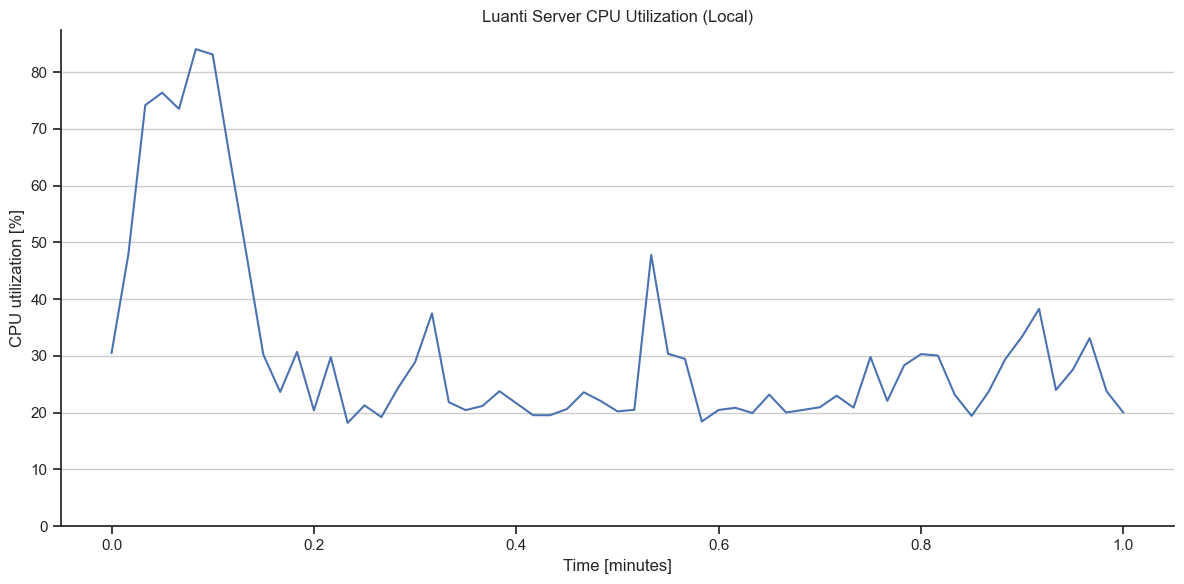

Average CPU utilization: 30.72%
Peak CPU utilization: 84.05%


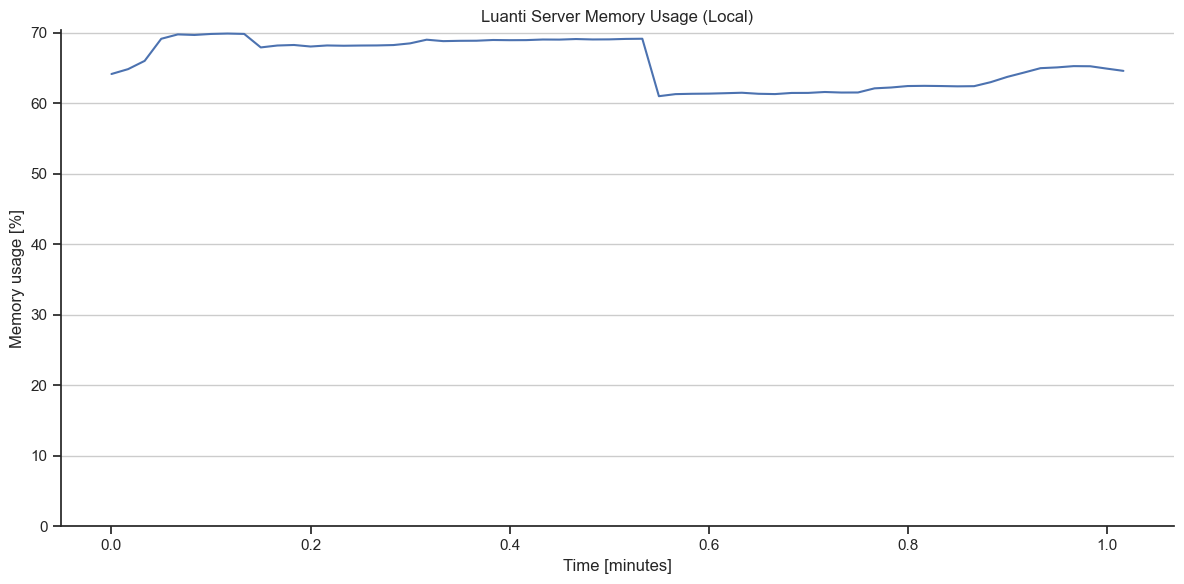

Average memory usage: 65.76%
Peak memory usage: 69.89%


In [4]:
def metrics_to_dataframe(metrics, metric_name):
    """Convert JSON metrics to DataFrame (reused from Minecraft analysis)."""
    filtered_metrics = [m for m in metrics if m.get('name') == metric_name]
    
    if not filtered_metrics:
        return pd.DataFrame()
    
    rows = []
    for metric in filtered_metrics:
        row = {
            'timestamp': metric['timestamp'],
            'host': metric.get('tags', {}).get('host', 'unknown')
        }
        
        # Add all fields as columns
        for field, value in metric.get('fields', {}).items():
            row[field] = value
            
        # Add relevant tags as columns
        for tag, value in metric.get('tags', {}).items():
            if tag != 'host':
                row[f'tag_{tag}'] = value
                
        rows.append(row)
    
    df = pd.DataFrame(rows)
    if not df.empty:
        # Convert timestamp to relative time in minutes
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp_m'] = df['timestamp'] / 60
    
    return df

# Analyze JSON metrics if available
if 'json_metrics' in all_data:
    json_metrics = all_data['json_metrics']
    metric_types = set(m.get('name') for m in json_metrics)
    print(f"Available JSON metric types: {sorted(metric_types)}")
    
    # CPU Analysis
    if 'cpu' in metric_types:
        cpu_df = metrics_to_dataframe(json_metrics, 'cpu')
        if not cpu_df.empty:
            print(f"\nCPU metrics: {len(cpu_df)} records")
            
            # Filter for total CPU
            if 'tag_cpu' in cpu_df.columns:
                total_cpu_df = cpu_df[cpu_df['tag_cpu'] == 'cpu-total'].copy()
                
                if 'usage_user' in total_cpu_df.columns:
                    total_cpu_df['cpu_util'] = (total_cpu_df['usage_user'] + 
                                              total_cpu_df.get('usage_system', 0))
                    
                    plt.figure(figsize=(12, 6))
                    ax = sns.lineplot(data=total_cpu_df, x="timestamp_m", y="cpu_util")
                    ax.grid(axis="y")
                    ax.set_ylim(bottom=0)
                    ax.set_ylabel("CPU utilization [%]")
                    ax.set_xlabel("Time [minutes]")
                    ax.set_title("Luanti Server CPU Utilization (Local)")
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"Average CPU utilization: {total_cpu_df['cpu_util'].mean():.2f}%")
                    print(f"Peak CPU utilization: {total_cpu_df['cpu_util'].max():.2f}%")
    
    # Memory Analysis
    if 'mem' in metric_types:
        mem_df = metrics_to_dataframe(json_metrics, 'mem')
        if not mem_df.empty and 'used_percent' in mem_df.columns:
            plt.figure(figsize=(12, 6))
            ax = sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent")
            ax.grid(axis="y")
            ax.set_ylim(bottom=0)
            ax.set_ylabel("Memory usage [%]")
            ax.set_xlabel("Time [minutes]") 
            ax.set_title("Luanti Server Memory Usage (Local)")
            plt.tight_layout()
            plt.show()
            
            print(f"Average memory usage: {mem_df['used_percent'].mean():.2f}%")
            print(f"Peak memory usage: {mem_df['used_percent'].max():.2f}%")
else:
    print("No JSON metrics available for analysis")

## CSV Metrics Analysis (Yardstick Results)

Analyze CSV-formatted metrics from Yardstick DAS5 experiments.

In [5]:
# Analyze CSV metrics from Yardstick if available
if 'csv_metrics' in all_data:
    csv_data = all_data['csv_metrics']
    print(f"Available CSV metrics: {list(csv_data.keys())}")
    
    # CPU Analysis from Yardstick data
    if 'cpu' in csv_data:
        cpu_df = csv_data['cpu'].copy()
        print(f"\nYardstick CPU data shape: {cpu_df.shape}")
        
        # Standard Yardstick CPU processing
        if 'timestamp' in cpu_df.columns:
            cpu_df['timestamp'] = cpu_df['timestamp'] - cpu_df['timestamp'].min()
            cpu_df['timestamp_m'] = cpu_df['timestamp'] / 60
            
        # Add node identification if available
        if 'host' in cpu_df.columns:
            # Create node labels
            unique_hosts = cpu_df['host'].unique()
            host_map = {host: f"Node-{i}" for i, host in enumerate(unique_hosts)}
            cpu_df['node'] = cpu_df['host'].map(host_map)
        
        # Filter for total CPU and calculate utilization
        if 'cpu' in cpu_df.columns:
            total_cpu_df = cpu_df[cpu_df['cpu'] == 'cpu-total'].copy()
            
            if 'time_active' in total_cpu_df.columns and 'time_idle' in total_cpu_df.columns:
                total_cpu_df['time_total'] = total_cpu_df['time_active'] + total_cpu_df['time_idle'] 
                total_cpu_df['util'] = 100 * total_cpu_df['time_active'] / total_cpu_df['time_total']
                
                plt.figure(figsize=(12, 6))
                if 'node' in total_cpu_df.columns:
                    ax = sns.lineplot(data=total_cpu_df, x="timestamp_m", y="util", hue="node")
                else:
                    ax = sns.lineplot(data=total_cpu_df, x="timestamp_m", y="util")
                
                ax.grid(axis="y")
                ax.set_ylim(bottom=0)
                ax.set_ylabel("CPU utilization [%]")
                ax.set_xlabel("Time [minutes]")
                ax.set_title("Luanti Server & Bot CPU Utilization (DAS5)")
                plt.tight_layout()
                plt.show()
                
                # Print statistics per node
                if 'node' in total_cpu_df.columns:
                    stats = total_cpu_df.groupby('node')['util'].agg(['mean', 'max', 'std']).round(2)
                    print("\nCPU Statistics by Node:")
                    print(stats)
                else:
                    print(f"Average CPU utilization: {total_cpu_df['util'].mean():.2f}%")
                    print(f"Peak CPU utilization: {total_cpu_df['util'].max():.2f}%")
    
    # Memory Analysis from Yardstick data
    if 'mem' in csv_data:
        mem_df = csv_data['mem'].copy()
        print(f"\nYardstick Memory data shape: {mem_df.shape}")
        
        if 'timestamp' in mem_df.columns:
            mem_df['timestamp'] = mem_df['timestamp'] - mem_df['timestamp'].min()
            mem_df['timestamp_m'] = mem_df['timestamp'] / 60
            
        if 'host' in mem_df.columns:
            unique_hosts = mem_df['host'].unique()
            host_map = {host: f"Node-{i}" for i, host in enumerate(unique_hosts)}
            mem_df['node'] = mem_df['host'].map(host_map)
        
        if 'used_percent' in mem_df.columns:
            plt.figure(figsize=(12, 6))
            if 'node' in mem_df.columns:
                ax = sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent", hue="node")
            else:
                ax = sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent")
                
            ax.grid(axis="y")
            ax.set_ylim(bottom=0)
            ax.set_ylabel("Memory utilization [%]")
            ax.set_xlabel("Time [minutes]")
            ax.set_title("Luanti Server & Bot Memory Usage (DAS5)")
            plt.tight_layout()
            plt.show()
            
            if 'node' in mem_df.columns:
                stats = mem_df.groupby('node')['used_percent'].agg(['mean', 'max', 'std']).round(2)
                print("\nMemory Statistics by Node:")
                print(stats)
    
    # Network Analysis if available
    if 'net' in csv_data:
        net_df = csv_data['net'].copy()
        print(f"\nNetwork data shape: {net_df.shape}")
        
        if 'timestamp' in net_df.columns:
            net_df['timestamp'] = net_df['timestamp'] - net_df['timestamp'].min()
            net_df['timestamp_m'] = net_df['timestamp'] / 60
            
        # Look for bytes sent/received columns
        net_cols = [col for col in net_df.columns if 'bytes' in col.lower()]
        if net_cols:
            plt.figure(figsize=(12, 6))
            for col in net_cols[:4]:  # Limit to first 4 columns
                sns.lineplot(data=net_df, x="timestamp_m", y=col, label=col)
            
            plt.grid(axis="y")
            plt.ylabel("Network Traffic [bytes]")
            plt.xlabel("Time [minutes]")
            plt.title("Luanti Network Activity (DAS5)")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
else:
    print("No CSV metrics available for analysis")

No CSV metrics available for analysis


## Server Log Analysis

Analyze Luanti server logs for player connections, performance events, and protocol-specific insights.

Server log events: 1
Event types: {'player_connection': 1}

Player connection events: 1


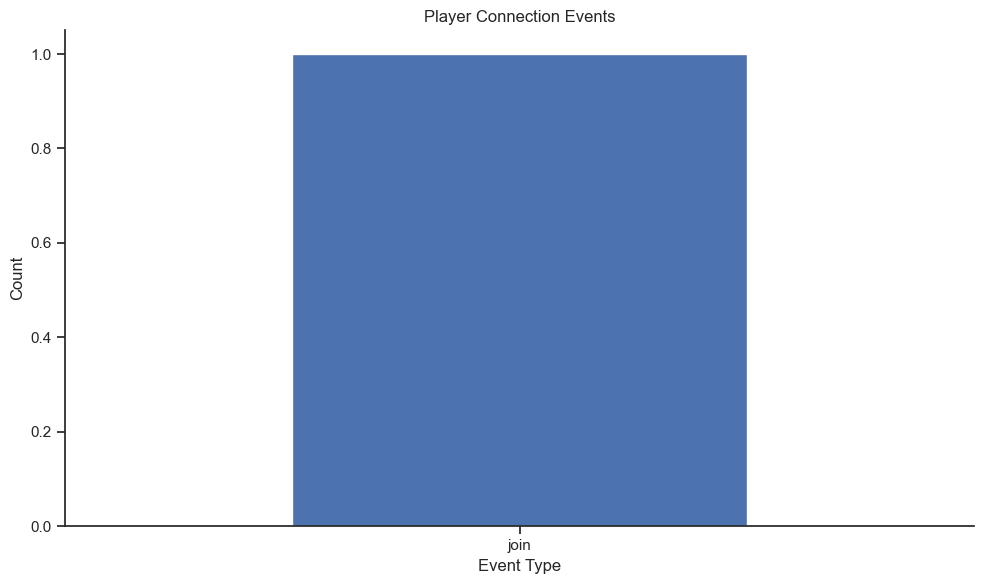

Connection event summary:
event
join    1
Name: count, dtype: int64


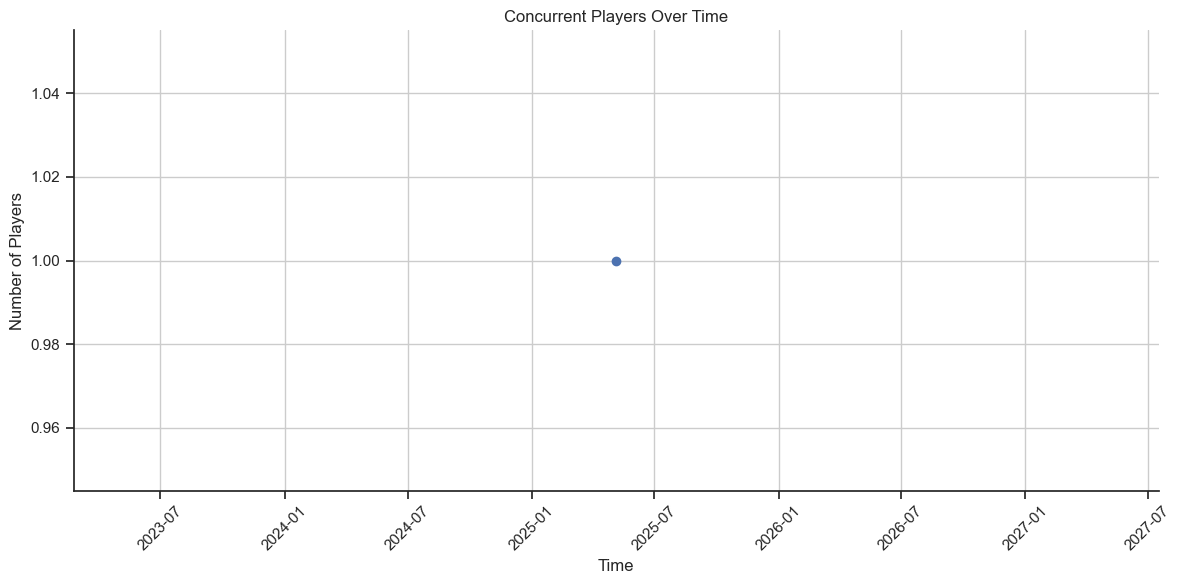

Peak concurrent players: 1


In [6]:
# Analyze server logs if available
if 'log_data' in all_data:
    log_df = all_data['log_data']
    print(f"Server log events: {len(log_df)}")
    print(f"Event types: {log_df['type'].value_counts().to_dict()}")
    
    # Player connection analysis
    connection_events = log_df[log_df['type'] == 'player_connection']
    if not connection_events.empty:
        print(f"\nPlayer connection events: {len(connection_events)}")
        
        # Count joins vs leaves
        event_counts = connection_events['event'].value_counts()
        
        plt.figure(figsize=(10, 6))
        event_counts.plot(kind='bar')
        plt.title("Player Connection Events")
        plt.ylabel("Count")
        plt.xlabel("Event Type")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        print("Connection event summary:")
        print(event_counts)
        
        # Timeline of connections if timestamps available
        if 'timestamp' in connection_events.columns and connection_events['timestamp'].notna().any():
            connection_events = connection_events.copy()
            connection_events['timestamp'] = pd.to_datetime(connection_events['timestamp'])
            connection_events = connection_events.sort_values('timestamp')
            
            # Calculate concurrent players over time
            concurrent_players = 0
            timeline = []
            
            for _, event in connection_events.iterrows():
                if event['event'] == 'join':
                    concurrent_players += 1
                elif event['event'] == 'leave':
                    concurrent_players = max(0, concurrent_players - 1)
                    
                timeline.append({
                    'timestamp': event['timestamp'],
                    'concurrent_players': concurrent_players
                })
            
            if timeline:
                timeline_df = pd.DataFrame(timeline)
                
                plt.figure(figsize=(12, 6))
                plt.plot(timeline_df['timestamp'], timeline_df['concurrent_players'], marker='o')
                plt.title("Concurrent Players Over Time")
                plt.ylabel("Number of Players")
                plt.xlabel("Time")
                plt.grid(True)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                
                print(f"Peak concurrent players: {timeline_df['concurrent_players'].max()}")
    
    # Performance warnings
    perf_warnings = log_df[log_df['type'] == 'performance_warning']
    if not perf_warnings.empty:
        print(f"\nPerformance warnings found: {len(perf_warnings)}")
        print("Sample warnings:")
        for warning in perf_warnings['line'].head(3):
            print(f"  {warning}")

else:
    print("No server log data available for analysis")
    print("To analyze logs:")
    print("1. Ensure Luanti server logs are saved to luanti_server/")
    print("2. Logs should contain timestamps and player events")
    print("3. Run a local benchmark with proper logging enabled")

## Combined Dashboard

Create a comprehensive dashboard combining all available data sources.

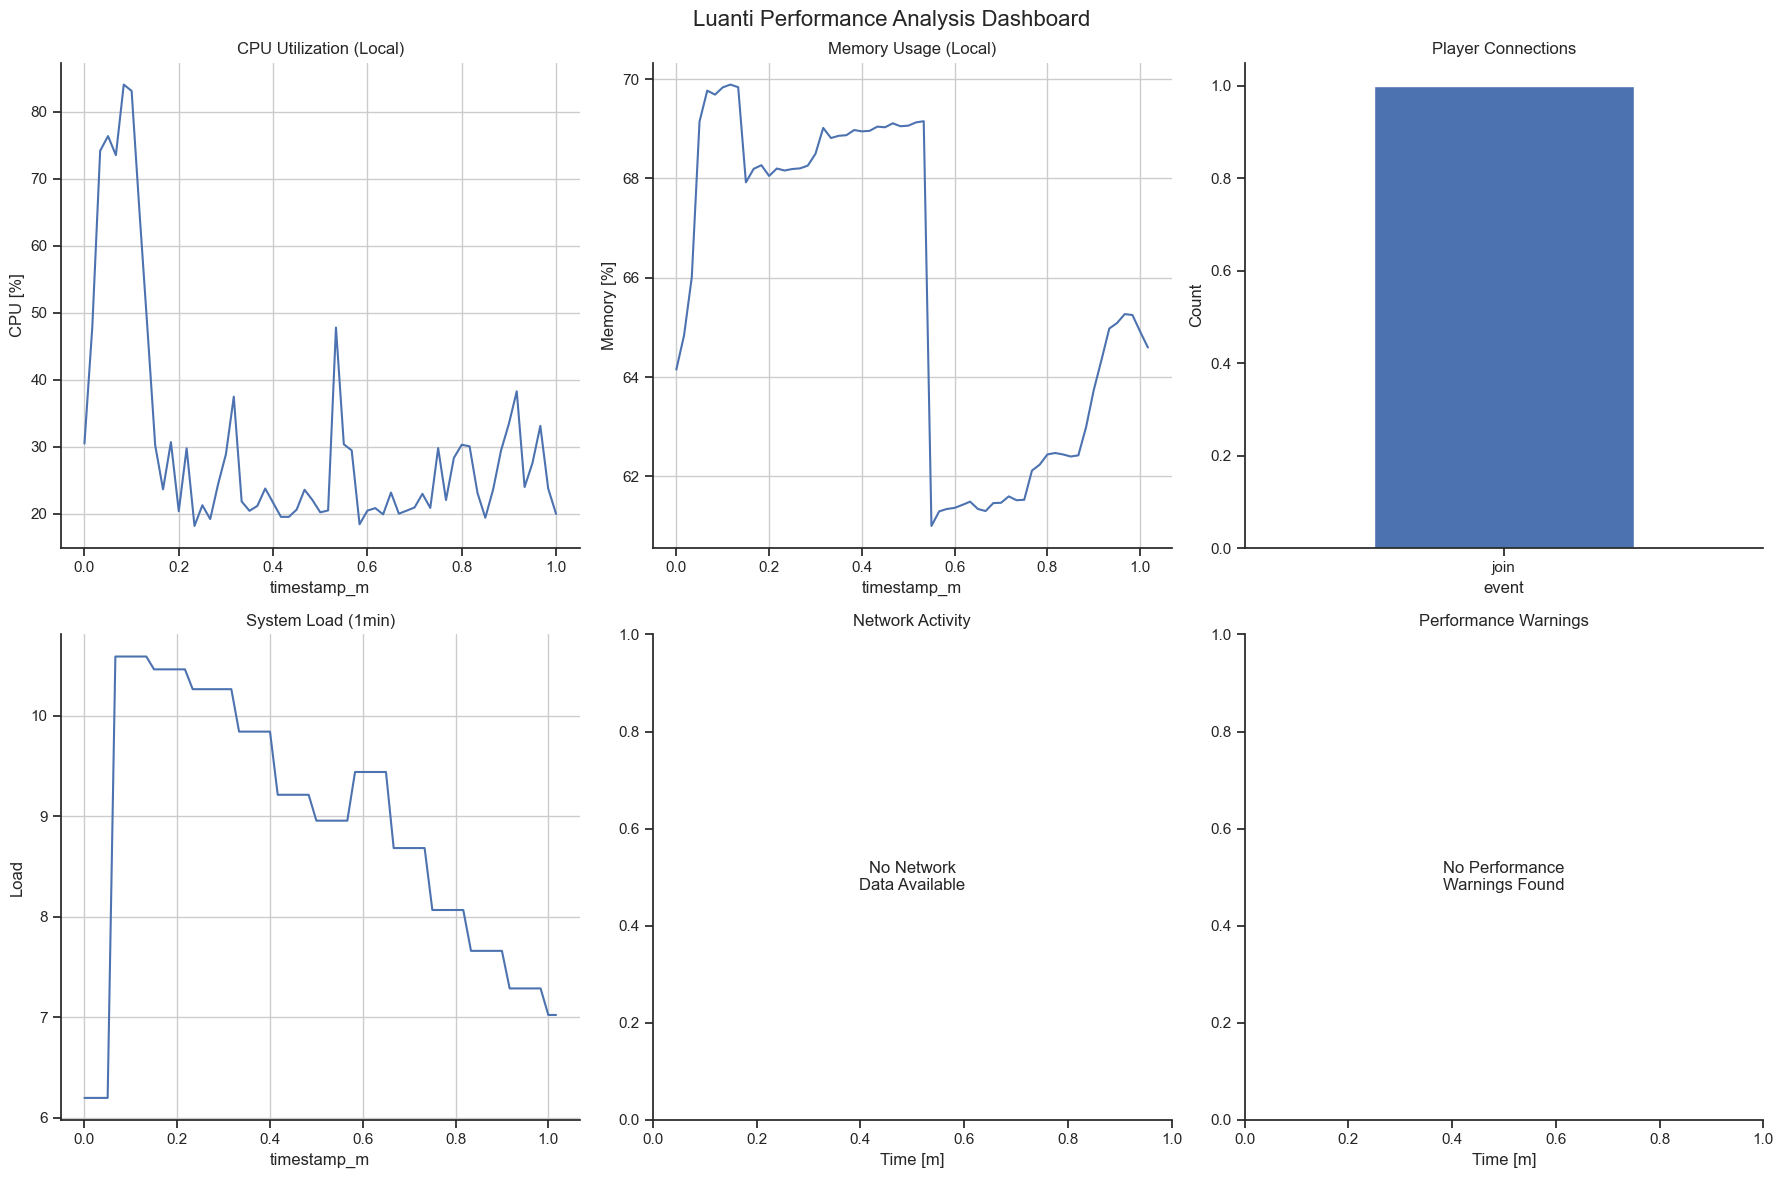

In [7]:
# Create a combined dashboard with available data
fig_rows = 2
fig_cols = 3
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18, 12))
fig.suptitle('Luanti Performance Analysis Dashboard', fontsize=16)

plot_count = 0

# Plot 1: CPU utilization (JSON or CSV)
if 'json_metrics' in all_data and 'cpu' in set(m.get('name') for m in all_data['json_metrics']):
    cpu_df = metrics_to_dataframe(all_data['json_metrics'], 'cpu')
    if not cpu_df.empty and 'tag_cpu' in cpu_df.columns:
        total_cpu_df = cpu_df[cpu_df['tag_cpu'] == 'cpu-total'].copy()
        if 'usage_user' in total_cpu_df.columns:
            total_cpu_df['cpu_util'] = total_cpu_df['usage_user'] + total_cpu_df.get('usage_system', 0)
            sns.lineplot(data=total_cpu_df, x="timestamp_m", y="cpu_util", ax=axes[0,0])
            axes[0,0].set_title('CPU Utilization (Local)')
            axes[0,0].set_ylabel('CPU [%]')
            axes[0,0].grid(True)
            plot_count += 1

elif 'csv_metrics' in all_data and 'cpu' in all_data['csv_metrics']:
    cpu_df = all_data['csv_metrics']['cpu'].copy()
    if 'timestamp' in cpu_df.columns:
        cpu_df['timestamp_m'] = (cpu_df['timestamp'] - cpu_df['timestamp'].min()) / 60
        total_cpu_df = cpu_df[cpu_df['cpu'] == 'cpu-total'].copy()
        if 'time_active' in total_cpu_df.columns:
            total_cpu_df['time_total'] = total_cpu_df['time_active'] + total_cpu_df['time_idle']
            total_cpu_df['util'] = 100 * total_cpu_df['time_active'] / total_cpu_df['time_total']
            sns.lineplot(data=total_cpu_df, x="timestamp_m", y="util", ax=axes[0,0])
            axes[0,0].set_title('CPU Utilization (DAS5)')
            axes[0,0].set_ylabel('CPU [%]')
            axes[0,0].grid(True)
            plot_count += 1

if plot_count == 0:
    axes[0,0].text(0.5, 0.5, 'No CPU Data\nAvailable', ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('CPU Utilization')

# Plot 2: Memory utilization
plot_count = 0
if 'json_metrics' in all_data and 'mem' in set(m.get('name') for m in all_data['json_metrics']):
    mem_df = metrics_to_dataframe(all_data['json_metrics'], 'mem')
    if not mem_df.empty and 'used_percent' in mem_df.columns:
        sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent", ax=axes[0,1])
        axes[0,1].set_title('Memory Usage (Local)')
        axes[0,1].set_ylabel('Memory [%]')
        axes[0,1].grid(True)
        plot_count += 1

elif 'csv_metrics' in all_data and 'mem' in all_data['csv_metrics']:
    mem_df = all_data['csv_metrics']['mem'].copy()
    if 'timestamp' in mem_df.columns and 'used_percent' in mem_df.columns:
        mem_df['timestamp_m'] = (mem_df['timestamp'] - mem_df['timestamp'].min()) / 60
        sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent", ax=axes[0,1])
        axes[0,1].set_title('Memory Usage (DAS5)')
        axes[0,1].set_ylabel('Memory [%]')
        axes[0,1].grid(True)
        plot_count += 1

if plot_count == 0:
    axes[0,1].text(0.5, 0.5, 'No Memory Data\nAvailable', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Memory Usage')

# Plot 3: Player connections timeline
if 'log_data' in all_data:
    log_df = all_data['log_data']
    connection_events = log_df[log_df['type'] == 'player_connection']
    
    if not connection_events.empty:
        event_counts = connection_events['event'].value_counts()
        event_counts.plot(kind='bar', ax=axes[0,2])
        axes[0,2].set_title('Player Connections')
        axes[0,2].set_ylabel('Count')
        axes[0,2].tick_params(axis='x', rotation=0)
    else:
        axes[0,2].text(0.5, 0.5, 'No Connection\nData Available', ha='center', va='center', transform=axes[0,2].transAxes)
        axes[0,2].set_title('Player Connections')
else:
    axes[0,2].text(0.5, 0.5, 'No Log Data\nAvailable', ha='center', va='center', transform=axes[0,2].transAxes)
    axes[0,2].set_title('Player Connections')

# Plot 4: System load (if available)
plot_count = 0
if 'json_metrics' in all_data and 'system' in set(m.get('name') for m in all_data['json_metrics']):
    system_df = metrics_to_dataframe(all_data['json_metrics'], 'system')
    if not system_df.empty and 'load1' in system_df.columns:
        sns.lineplot(data=system_df, x="timestamp_m", y="load1", ax=axes[1,0])
        axes[1,0].set_title('System Load (1min)')
        axes[1,0].set_ylabel('Load')
        axes[1,0].grid(True)
        plot_count += 1

if plot_count == 0:
    axes[1,0].text(0.5, 0.5, 'No System Load\nData Available', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('System Load')

# Plot 5: Network activity (if available)
plot_count = 0
if 'csv_metrics' in all_data and 'net' in all_data['csv_metrics']:
    net_df = all_data['csv_metrics']['net'].copy()
    if 'timestamp' in net_df.columns:
        net_df['timestamp_m'] = (net_df['timestamp'] - net_df['timestamp'].min()) / 60
        
        # Look for bytes columns
        bytes_cols = [col for col in net_df.columns if 'bytes' in col.lower()]
        if bytes_cols:
            for col in bytes_cols[:2]:  # Max 2 lines
                sns.lineplot(data=net_df, x="timestamp_m", y=col, ax=axes[1,1], label=col)
            axes[1,1].set_title('Network Activity')
            axes[1,1].set_ylabel('Bytes')
            axes[1,1].grid(True)
            axes[1,1].legend()
            plot_count += 1

if plot_count == 0:
    axes[1,1].text(0.5, 0.5, 'No Network\nData Available', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Network Activity')

# Plot 6: Performance warnings
if 'log_data' in all_data:
    log_df = all_data['log_data']
    warnings = log_df[log_df['type'] == 'performance_warning']
    
    if not warnings.empty:
        # Create a simple bar chart of warning count
        warning_count = len(warnings)
        axes[1,2].bar(['Performance Warnings'], [warning_count])
        axes[1,2].set_title(f'Performance Issues ({warning_count})')
        axes[1,2].set_ylabel('Count')
    else:
        axes[1,2].text(0.5, 0.5, 'No Performance\nWarnings Found', ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('Performance Warnings')
else:
    axes[1,2].text(0.5, 0.5, 'No Warning\nData Available', ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Performance Warnings')

# Set common x-axis labels where applicable
for ax in axes.flat:
    if ax.get_xlabel() == '':
        ax.set_xlabel('Time [m]')

plt.tight_layout()
plt.show()

## Benchmark Summary and Insights

Generate a comprehensive summary of the Luanti benchmark analysis.

In [ ]:
print("="*60)
print("LUANTI BENCHMARK ANALYSIS SUMMARY")
print("="*60)

# Data source summary
print(f"Data sources analyzed: {len(all_data)}")
for source_type, data in all_data.items():
    if source_type == 'json_metrics':
        print(f"  • JSON metrics: {len(data)} records")
        metric_types = set(m.get('name') for m in data)
        print(f"    Metric types: {sorted(metric_types)}")
        
        if data:
            duration = (max(m['timestamp'] for m in data) - min(m['timestamp'] for m in data)) / 60
            print(f"    Duration: {duration:.1f} minutes")
            
    elif source_type == 'csv_metrics':
        print(f"  • CSV metrics: {len(data)} files")
        print(f"    Metric types: {list(data.keys())}")
        
        # Calculate duration from first available metric
        first_metric = next(iter(data.values()))
        if 'timestamp' in first_metric.columns:
            duration = (first_metric['timestamp'].max() - first_metric['timestamp'].min()) / 60
            print(f"    Duration: {duration:.1f} minutes")
            
    elif source_type == 'log_data':
        print(f"  • Server logs: {len(data)} events")
        if not data.empty:
            event_types = data['type'].value_counts().to_dict()
            print(f"    Event types: {event_types}")

print("\n" + "="*60)
print("PERFORMANCE INSIGHTS")
print("="*60)

# CPU insights
cpu_insights = []
if 'json_metrics' in all_data:
    json_metrics = all_data['json_metrics']
    if 'cpu' in set(m.get('name') for m in json_metrics):
        cpu_df = metrics_to_dataframe(json_metrics, 'cpu')
        if not cpu_df.empty and 'tag_cpu' in cpu_df.columns:
            total_cpu_df = cpu_df[cpu_df['tag_cpu'] == 'cpu-total']
            if 'usage_user' in total_cpu_df.columns:
                avg_cpu = (total_cpu_df['usage_user'] + total_cpu_df.get('usage_system', 0)).mean()
                cpu_insights.append(f"Local average CPU usage: {avg_cpu:.1f}%")

if 'csv_metrics' in all_data and 'cpu' in all_data['csv_metrics']:
    cpu_df = all_data['csv_metrics']['cpu']
    if 'cpu' in cpu_df.columns:
        total_cpu_df = cpu_df[cpu_df['cpu'] == 'cpu-total']
        if 'time_active' in total_cpu_df.columns:
            total_cpu_df['util'] = 100 * total_cpu_df['time_active'] / (total_cpu_df['time_active'] + total_cpu_df['time_idle'])
            
            if 'host' in total_cpu_df.columns:
                for host in total_cpu_df['host'].unique():
                    host_data = total_cpu_df[total_cpu_df['host'] == host]
                    avg_cpu = host_data['util'].mean()
                    cpu_insights.append(f"DAS5 {host} average CPU: {avg_cpu:.1f}%")
            else:
                avg_cpu = total_cpu_df['util'].mean()
                cpu_insights.append(f"DAS5 average CPU usage: {avg_cpu:.1f}%")

for insight in cpu_insights:
    print(f"• {insight}")

# Memory insights  
mem_insights = []
if 'json_metrics' in all_data:
    if 'mem' in set(m.get('name') for m in all_data['json_metrics']):
        mem_df = metrics_to_dataframe(all_data['json_metrics'], 'mem')
        if not mem_df.empty and 'used_percent' in mem_df.columns:
            avg_mem = mem_df['used_percent'].mean()
            mem_insights.append(f"Local average memory usage: {avg_mem:.1f}%")

if 'csv_metrics' in all_data and 'mem' in all_data['csv_metrics']:
    mem_df = all_data['csv_metrics']['mem']
    if 'used_percent' in mem_df.columns:
        if 'host' in mem_df.columns:
            for host in mem_df['host'].unique():
                host_data = mem_df[mem_df['host'] == host]
                avg_mem = host_data['used_percent'].mean()
                mem_insights.append(f"DAS5 {host} average memory: {avg_mem:.1f}%")
        else:
            avg_mem = mem_df['used_percent'].mean()
            mem_insights.append(f"DAS5 average memory usage: {avg_mem:.1f}%")

for insight in mem_insights:
    print(f"• {insight}")

# Player connection insights
if 'log_data' in all_data:
    log_df = all_data['log_data']
    connections = log_df[log_df['type'] == 'player_connection']
    if not connections.empty:
        joins = len(connections[connections['event'] == 'join'])
        leaves = len(connections[connections['event'] == 'leave'])
        print(f"• Player connections: {joins} joins, {leaves} leaves")
        
        if joins > 0:
            peak_players = joins - leaves if joins > leaves else joins
            print(f"• Estimated peak concurrent players: {peak_players}")
    
    warnings = log_df[log_df['type'] == 'performance_warning']
    if not warnings.empty:
        print(f"• Performance warnings detected: {len(warnings)}")
    else:
        print(f"• No performance warnings found")

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

# Generate recommendations based on data
recommendations = []

# Check if we have any data at all
if not all_data:
    recommendations.append("Run a Luanti benchmark to collect performance data")
    recommendations.append("Enable server logging for player connection analysis")
    recommendations.append("Set up Telegraf monitoring for system metrics")

# CPU recommendations
if cpu_insights:
    if any("Local" in insight and float(insight.split(": ")[1].replace("%", "")) > 80 for insight in cpu_insights if ": " in insight):
        recommendations.append("High local CPU usage detected - consider reducing bot count or server load")
    
    if any("DAS5" in insight for insight in cpu_insights):
        recommendations.append("Compare local vs DAS5 performance to understand scaling characteristics")

# Memory recommendations  
if mem_insights:
    if any(float(insight.split(": ")[1].replace("%", "")) > 90 for insight in mem_insights if ": " in insight):
        recommendations.append("High memory usage detected - monitor for memory leaks")

# Log-based recommendations
if 'log_data' in all_data:
    log_df = all_data['log_data']
    if len(log_df[log_df['type'] == 'performance_warning']) > 0:
        recommendations.append("Performance warnings found in logs - investigate server lag issues")

if not recommendations:
    recommendations.append("Performance looks healthy based on available data")
    recommendations.append("Consider running longer benchmarks for better trend analysis")
    recommendations.append("Add more bots to test scalability limits")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "="*60)

## Export and Next Steps

Export processed data and provide guidance for further analysis.

In [ ]:
# Export processed data for further analysis
export_dir = Path("luanti_analysis_exports")
export_dir.mkdir(exist_ok=True)

exported_files = []

# Export JSON metrics as CSV
if 'json_metrics' in all_data:
    json_metrics = all_data['json_metrics']
    metric_types = set(m.get('name') for m in json_metrics)
    
    for metric_name in metric_types:
        df = metrics_to_dataframe(json_metrics, metric_name)
        if not df.empty:
            output_file = export_dir / f"local_{metric_name}.csv"
            df.to_csv(output_file, index=False)
            exported_files.append(output_file)

# Copy/export CSV metrics
if 'csv_metrics' in all_data:
    for metric_name, df in all_data['csv_metrics'].items():
        output_file = export_dir / f"das5_{metric_name}.csv"
        df.to_csv(output_file, index=False)
        exported_files.append(output_file)

# Export log analysis
if 'log_data' in all_data:
    output_file = export_dir / "server_log_analysis.csv"
    all_data['log_data'].to_csv(output_file, index=False)
    exported_files.append(output_file)

# Create analysis summary
summary_file = export_dir / "analysis_summary.txt"
with open(summary_file, 'w') as f:
    f.write("LUANTI BENCHMARK ANALYSIS SUMMARY\n")
    f.write("=" * 40 + "\n\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Data sources: {len(all_data)}\n")
    f.write(f"Exported files: {len(exported_files)}\n\n")
    
    f.write("Data Sources:\n")
    for source_type in all_data.keys():
        f.write(f"  - {source_type}\n")
    
    f.write("\nExported Files:\n")
    for file_path in exported_files:
        f.write(f"  - {file_path.name}\n")

exported_files.append(summary_file)

print(f"Exported {len(exported_files)} files to {export_dir}/")
for file_path in exported_files:
    print(f"  • {file_path.name}")

print(f"\nNext Steps:")
print(f"1. Use exported CSV files for detailed statistical analysis")
print(f"2. Compare local vs DAS5 performance characteristics")
print(f"3. Run longer benchmarks for trend analysis") 
print(f"4. Investigate any performance warnings found in logs")
print(f"5. Create custom analysis scripts for specific metrics")

print(f"\nFiles ready for:")
print(f"  • Excel/spreadsheet analysis")
print(f"  • Statistical modeling with R/Python")
print(f"  • Integration with other benchmark tools")
print(f"  • Comparison with Minecraft benchmark results")